In [1]:
# kaggle execution things
"""
import sys

if True:
    !git clone https://github.com/DavidCanoRosillo/PIKAN.git

if True:
    _ = !pip install -r /kaggle/working/PIKAN/requirements.txt
"""

'\nimport sys\n\nif True:\n    !git clone https://github.com/DavidCanoRosillo/PIKAN.git\n\nif True:\n    _ = !pip install -r /kaggle/working/PIKAN/requirements.txt\n'

In [2]:
# kaggle execution things
# sys.path.append('/kaggle/working/PIKAN')

In [3]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import numpy as np
from pikan.model_utils import GeneralizedMLP, sobol_sample
from jax import grad, vmap, jit
from jax.scipy.special import gamma
from functools import partial
import optax

import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

jax.devices()

[CpuDevice(id=0)]

In [4]:
model = GeneralizedMLP(
    kernel_init=nn.initializers.glorot_normal(),
    num_input=2,
    num_output=1,
    use_fourier_feats=True,
    layer_sizes=[128, 128],
)

key = jax.random.PRNGKey(0)
collocs = jnp.ones((2))
params = model.init(key, collocs)['params']
model.apply({"params": params}, collocs)

Array([0.8603496], dtype=float32)

In [5]:
# Define the inference function
def inference(params, model, x, t):
    x = jnp.stack([x,t])
    return model.apply({'params': params}, x)

inference(params, model, 0, 1)

Array([-0.10571431], dtype=float32)

In [6]:
def inference(params, x, t):
    output = model.apply({'params': params}, jnp.array([x, t]))
    return output[0]

def get_caputo_derivative(inference):
    @jax.jit
    def caputo_derivative(params, x, t, alpha, dt=1e-3, num_steps = 500):
        """
        Compute the Caputo derivative of order alpha for a function f(x, t) with respect to t.
    
        Parameters:
        - f: A function f(x, t) that takes two arguments, x and t.
        - x: The spatial variable.
        - t: The time variable.
        - alpha: The order of the Caputo derivative (0 < alpha < 1).
        - dt: The time step for discretization.
    
        Returns:
        - The Caputo derivative of f(x, t) at time t.
        """
        # Define the integrand
        def integrand(tau):
            return grad(inference, 2)(params, x, tau) / (t - tau)**alpha
    
        # Fixed number of steps for static shape
        tau_values = jnp.linspace(0, t - dt, num_steps)  # Exclude t
        integrand_values = vmap(integrand)(tau_values)
    
        # Compute the integral using the trapezoidal rule
        integral = jnp.trapezoid(integrand_values, tau_values)
    
        # Normalize by the gamma function
        return integral / gamma(1 - alpha)
    
    return caputo_derivative
    
x = 1.0
t = 1.0
alpha = 0.5

caputo_derivative_fn = get_caputo_derivative(inference)
caputo_deriv = caputo_derivative_fn(params, x, t, alpha)

print("Caputo Derivative:", caputo_deriv)

Caputo Derivative: 1.4770213


In [7]:
BS = 64
collocs = sobol_sample(np.array([-1, 0]), np.array([1, 1]), BS)

jax.vmap(caputo_derivative_fn, (None, 0,0,None))(params, collocs[:, 0], collocs[:, 1], alpha), collocs.shape

(Array([-0.27496162,  1.3696132 ,  1.3379728 , -1.1451266 ,  0.7656417 ,
        -1.8686527 ,  0.5999001 ,  2.2843006 ,  0.06521966,  1.7820852 ,
         0.3882515 ,  1.4588891 ,  0.08513623, -0.37635502,  2.2886276 ,
        -2.699692  ,  0.8935667 ,  2.3997037 , -0.9090736 ,  1.1331003 ,
         2.029574  , -0.2268472 ,  1.6942438 ,  0.36141443, -1.3653224 ,
         3.0029094 ,  1.2556036 , -2.7805388 , -0.8406527 ,  0.9291428 ,
         0.87108123, -2.9609854 , -1.1159889 ,  3.1835616 , -0.29230067,
         1.7592266 ,  1.3322989 , -0.89537567,  1.7069498 ,  1.9989326 ,
        -1.0422965 , -1.1210685 , -1.6130804 , -1.4032934 ,  1.9907401 ,
        -0.57933635, -0.04663802, -1.5764637 ,  0.4351028 ,  2.64294   ,
         0.39743844, -0.11782882, -0.86687016, -0.62964386,  0.4648188 ,
        -3.1796162 ,  2.011822  ,  1.7924334 , -0.2549005 , -0.46136186,
         1.9871063 , -0.6813572 ,  2.3144236 , -0.63255554], dtype=float32),
 (64, 2))

In [8]:
# caputo diffusion on 1d
class fractional_diffusion():
    def __init__(self, model, bc_l, bc_r, ic_func, alpha, dom=[-1,1]):
        self.bc_l = bc_l # boundary vals
        self.bc_r = bc_r

        self.ic_collocs = jnp.linspace(dom[0], dom[1], 1000)
        self.ic_vals = ic_func(self.ic_collocs) # t_0 values
        
        self.alpha = alpha
        self.dom = dom

        self.caputo_derivative = get_caputo_derivative(self.neural_net)

        # paralellize for faster computation
        self.neural_net_fn = jax.vmap(self.neural_net, (None, 0, 0))
        self.residual_loss_fn = jax.vmap(self.residual_loss, (None, 0, 0))

        self.D = 1
        
    def neural_net(self, params, x, t):
        output = model.apply({'params': params}, jnp.array([x, t]))
        return output[0]

    def residual_loss(self, params, x, t):
        f_derivative = self.caputo_derivative(params, x, t, self.alpha)
        laplacian = grad(grad(self.neural_net, argnums=1), argnums=1)(params, x, t)
        
        return f_derivative - self.D*laplacian

    def mse(self, arr):
        return jnp.sum(arr**2)
    
    @partial(jit, static_argnums=(0,))
    def loss(self, params, collocs):
        ic_preds = self.neural_net_fn(params, self.ic_collocs, jnp.zeros_like(self.ic_collocs))
        
        bc_l_preds = self.neural_net_fn(params, jnp.full_like(collocs[:,1], self.dom[0]), collocs[:,1])
        bc_r_preds = self.neural_net_fn(params, jnp.full_like(collocs[:,1], self.dom[1]), collocs[:,1])

        eq_loss = self.residual_loss_fn(params, collocs[:,0], collocs[:,1])

        # losses could be added with custom weights, TODO gradnorm
        loss = self.mse(ic_preds - self.ic_vals) + self.mse(bc_l_preds - self.bc_l) + \
               self.mse(bc_r_preds - self.bc_r) + 1e-3*self.mse(eq_loss)

        new_loc_w = 0 # maybe implement local weights
        return loss, new_loc_w 

def ic_func(x, sigma=0.3):
    return jnp.exp(-x**2 / (2 * sigma**2)) * (1 - x**2)

# ic_func=lambda x: jnp.cos(x*jnp.pi/2)
fdiff = fractional_diffusion(model, 0, 0, ic_func=ic_func, alpha=.5)
fdiff.neural_net(params, 0., 1.), fdiff.residual_loss(params, 0., 1.)

BS = 64
collocs = sobol_sample(np.array([-1, 0]), np.array([1, 1]), BS)
fdiff.loss(params, collocs)

(Array(1061.3048, dtype=float32), Array(0, dtype=int32, weak_type=True))

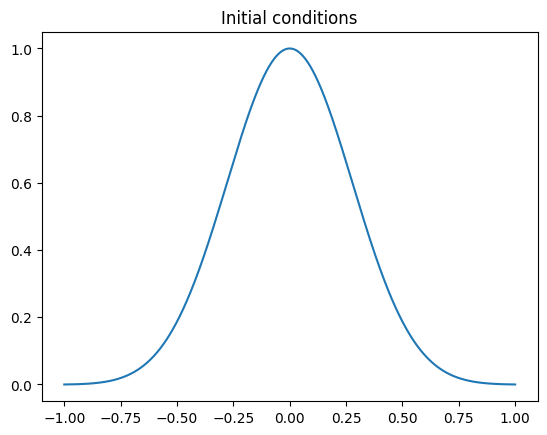

In [9]:
plt.plot(fdiff.ic_collocs, fdiff.ic_vals)
plt.title('Initial conditions')
_ = plt.plot()

In [10]:
# Define your gradient function
grad_fn = jax.value_and_grad(fdiff.loss, has_aux=True)

# Define the training loop
def train_step(params, collocs, opt_state):
    # Compute loss and gradients
    (loss, new_loc_w), grads = grad_fn(params, collocs)

    # Apply gradients to update the parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

In [11]:
EPOCHS = 1000

# Define a cosine decay learning rate schedule
# Learning rate schedule (cosine decay)
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-3,      # Initial learning rate
    decay_steps=2000,     # Total number of decay steps
    alpha=0.1             # Final learning rate multiplier
)

# Optimizer setup with Adam
optimizer = optax.adamw(
    learning_rate=schedule_fn,
    b1=0.9,               # Beta1
    b2=0.999,             # Beta2
    eps=1e-8              # Epsilon
)

opt_state = optimizer.init(params)

In [12]:
# Function to save parameters and state
def save_checkpoint(params, opt_state, epoch, filename):
    with open(filename, "wb") as f:
        pickle.dump({'params': params, 'opt_state': opt_state, 'epoch': epoch}, f)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(filename, params, state):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            checkpoint = pickle.load(f)
        print(f"Checkpoint loaded from epoch {checkpoint['epoch']}")
        return checkpoint['params'], checkpoint['opt_state'], checkpoint['epoch']
    return params, state, 0 

In [13]:
# Define constants
BS = 2048
EPOCHS = 3000
TMAX = 1
CHECKPOINT_FILE = "diff_v8.pkl"

# Initialize or load checkpoint
params, opt_state, start_epoch = load_checkpoint(CHECKPOINT_FILE, params, opt_state)

# Main training loop
for i in (pbar := tqdm(range(start_epoch, EPOCHS))):
    collocs = sobol_sample(np.array([-1, 0]), np.array([1, TMAX]), BS)
    params, opt_state, loss = train_step(params, collocs, opt_state)
    
    if i % 50 == 0:
        pbar.set_description(f"Loss {loss: .8f}")
    
    if i % 250 == 0:  # Save every x epochs
        save_checkpoint(params, opt_state, i, CHECKPOINT_FILE)

save_checkpoint(params, opt_state, i, CHECKPOINT_FILE)

'\n# Define constants\nBS = 2048\nEPOCHS = 3000\nTMAX = 1\nCHECKPOINT_FILE = "diff_v8.pkl"\n\n# Initialize or load checkpoint\nparams, opt_state, start_epoch = load_checkpoint(CHECKPOINT_FILE, params, opt_state)\n\n# Main training loop\nfor i in (pbar := tqdm(range(start_epoch, EPOCHS))):\n    collocs = sobol_sample(np.array([-1, 0]), np.array([1, TMAX]), BS)\n    params, opt_state, loss = train_step(params, collocs, opt_state)\n    \n    if i % 50 == 0:\n        pbar.set_description(f"Loss {loss: .8f}")\n    \n    if i % 250 == 0:  # Save every x epochs\n        save_checkpoint(params, opt_state, i, CHECKPOINT_FILE)\n\nsave_checkpoint(params, opt_state, i, CHECKPOINT_FILE)\n'

In [14]:
CHECKPOINT_FILE = "diff_v8.pkl"

# Initialize or load checkpoint
params, opt_state, start_epoch = load_checkpoint(CHECKPOINT_FILE, params, opt_state)

Checkpoint loaded from epoch 2999


In [15]:
x_space = jnp.linspace(-1, 1, 100)
t_space = jnp.linspace(0, 1, 50)

x_mesh, t_mesh = jnp.meshgrid(x_space, t_space, indexing='ij')
x_flat = x_mesh.reshape(-1)
t_flat = t_mesh.reshape(-1) 

u_flat = fdiff.neural_net_fn(params, x_flat, t_flat)
u_xt = u_flat.reshape(x_mesh.shape) 

In [16]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import PillowWriter
from IPython.display import HTML

# Initialize the figure
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(x_space.min(), x_space.max())
ax.set_ylim(u_xt.min(), u_xt.max())
ax.set_xlabel('x')
ax.set_ylabel('u(x, t)')
ax.set_title('Animation of u(x, t)')

# Animation update function
def update(frame):
    line.set_data(x_space, u_xt[:, frame])  # Set x and corresponding u values
    ax.set_title(r'Animation of $u(x, t)$ at $\Delta t = {:.2f}$'.format(t_space[frame]))
    return line,

# Create animation
ani = anim.FuncAnimation(
    fig, update, frames=len(t_space), blit=True, interval=100
)

plt.close(fig)
ani.save('CaputoDiffusion.gif', writer=PillowWriter(fps=15))

HTML(ani.to_jshtml())